In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import astropy.constants as c
import random
from scipy.special import logsumexp
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [3]:
srate = 4096*4
t_range=np.arange(-1,1,1/srate)
input = dict(model_list = [(2,2,0, 'p')],
             t_init = 0,
             segment_length = 0.2,
             srate = 4096*4,
             ra = None, dec = None,)
mmax = 8.4 * 1e-21

# NNI

## Likelihood

In [4]:
def signal_creator():
    global signal, signal220, signal221, t_range, injected
    injected = (random.uniform(60, 110), random.uniform(0.1,0.8))
    mass = qnm_filter.Filter.mass_unit(injected[0])
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]

    mmax = 8.4 * 1e-21
    phase1 = np.pi/3 #random.uniform(0, 2*np.pi)
    A220x = mmax*np.cos(phase1)
    A220y = mmax*np.sin(phase1)
    phase2 = np.pi/3 #random.uniform(0, 2*np.pi)
    A221x = mmax*np.cos(phase2)
    A221y = mmax*np.sin(phase2)

    power220 = random.uniform(0.5, 1)
    power221 = random.uniform(0.5, 1)
    amp220 = np.sqrt(power220)
    amp221 = np.sqrt(power221)

    sampling_frequency = 4096 * 1  # in Hz
    duration = 4  # in second
    t_range = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real(amp220 * (A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(t_range / mass)))
    signal221 = np.real(amp221 * (A221x + 1j * A221y) * np.exp(-1j * omega221 * np.abs(t_range / mass)))
    signal = signal220+signal221

In [5]:
def injection_likelihood(acf_scale):
    fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=0.0)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.condition_data('original_data')
    fit.compute_acfs('original_data')
    temp_acf = np.full(len(fit.acfs['H1']), 0, dtype = np.double)
    temp_acf[0] = (mmax)**2*acf_scale
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    likelihood220_221 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p'), (2,2,1,'p')])
    likelihood220 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
    
    fit.original_data['H1'] = qnm_filter.RealData(signal220, index=t_range)
    fit.condition_data('original_data')
    template = fit.truncate_data(fit.original_data)['H1']
    SNR220 = fit.compute_SNR(None, template, 'H1', optimal=True)
    
    fit.original_data['H1'] = qnm_filter.RealData(signal221, index=t_range)
    fit.condition_data('original_data')
    template = fit.truncate_data(fit.original_data)['H1']
    SNR221 = fit.compute_SNR(None, template, 'H1', optimal=True)
    
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.condition_data('original_data')
    template = fit.truncate_data(fit.original_data)['H1']
    SNRtot = fit.compute_SNR(None, template, 'H1', optimal=True)
    return np.array([SNR220, SNR221, SNRtot, likelihood220_221 - likelihood220])

In [6]:
result_arr = np.array([])
acf_space = np.linspace(0.1, 1, 50)

for i in acf_space:
    signal_creator()
    result = injection_likelihood(i)
    result_arr = np.append(result_arr, result)

result_arr = result_arr.reshape(len(acf_space), 4)

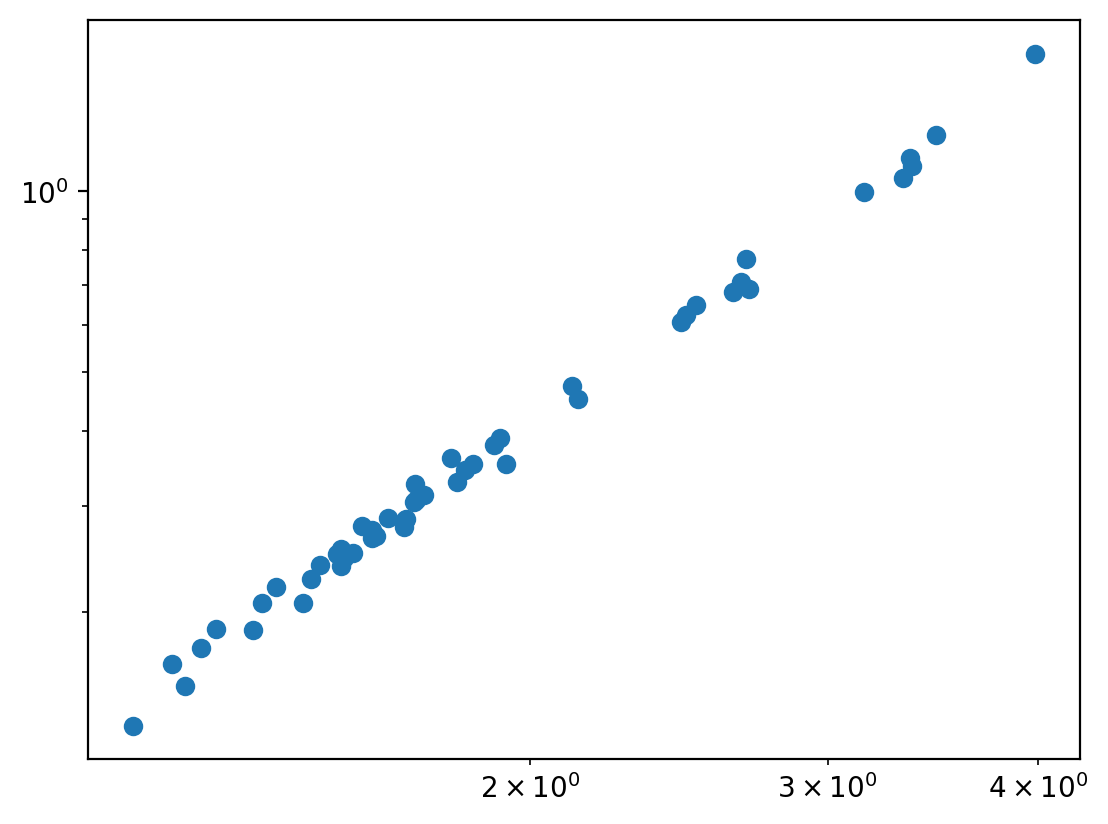

In [7]:
pl.loglog(result_arr[:,1], result_arr[:,3], 'o')

In [8]:
print(np.polyfit(np.log10(result_arr[:,1]), np.log10(result_arr[:,3]),deg=1, cov=False))

[ 1.96443323 -0.97885924]


# Colored noise

In [44]:
def BILBY_signal(noise_scale):
    global signal, signal220, signal221, t_range, noise, mass
    injected = (random.uniform(60, 110), random.uniform(0.1,0.8))
    mass = qnm_filter.Filter.mass_unit(injected[0])
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]

    mmax = 8.4 * 1e-21
    phase1 = random.uniform(0, 2*np.pi)
    A220x = mmax*np.cos(phase1)
    A220y = mmax*np.sin(phase1)
    phase2 = random.uniform(0, 2*np.pi)
    A221x = mmax*np.cos(phase2)
    A221y = mmax*np.sin(phase2)

    power220 = random.uniform(0.5, 1)
    power221 = random.uniform(0.5, 1)
    amp220 = np.sqrt(power220)
    amp221 = np.sqrt(power221)

    sampling_frequency = 4096 * 1  # in Hz
    duration = 4  # in second
    t_range = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real(amp220 * (A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(t_range / mass)))
    signal221 = np.real(amp221 * (A221x + 1j * A221y) * np.exp(-1j * omega221 * np.abs(t_range / mass)))

    bilby_ifo = qnm_filter.set_bilby_predefined_ifo(
	"H1", sampling_frequency, duration, start_time=-duration / 2
    )
    noise = qnm_filter.bilby_get_strain(bilby_ifo, 0.0)	
    signal = signal220+signal221+noise*noise_scale

## Likelihood

In [45]:
def BILBY_likelihood(noise_scale):
    fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=3*mass)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.condition_data('original_data')
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise*noise_scale, index=t_range)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    data = fit.truncate_data(fit.original_data)['H1']

    likelihood220_221 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p'), (2,2,1,'p')])
    likelihood220 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
        
    fit.original_data['H1'] = qnm_filter.RealData(signal221+noise*noise_scale, index=t_range)
    fit.condition_data('original_data')
    fit.pure_nr = {}
    fit.pure_nr['H1'] = qnm_filter.RealData(signal221, index=t_range)
    fit.condition_data("pure_nr")
    data = fit.truncate_data(fit.original_data)['H1']
    template = fit.truncate_data(fit.pure_nr)['H1']
    SNR221_MF = fit.compute_SNR(data, template, 'H1', optimal=False)
    
    return np.array([SNR221_MF, likelihood220_221 - likelihood220])

In [46]:
result_arr = np.array([])
acf_space = np.logspace(-1, 1.5, 50)

for i in acf_space:
    BILBY_signal(i)
    result = BILBY_likelihood(i)
    result_arr = np.append(result_arr, result)

result_arr = result_arr.reshape(len(acf_space), 2)

Text(0.5, 1.0, 'MF SNR')

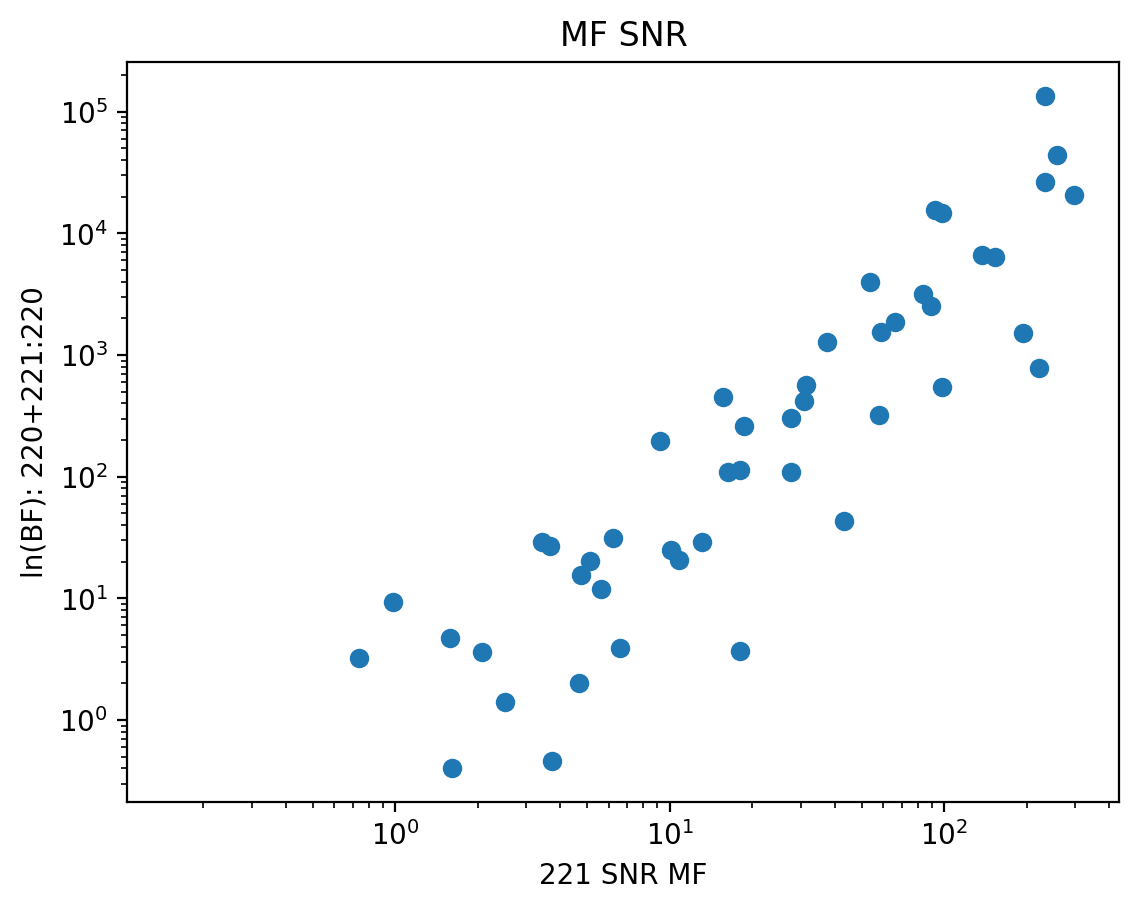

In [47]:
pl.loglog(result_arr[:,0], result_arr[:,1], 'o')
pl.xlabel("221 SNR MF")
pl.ylabel("ln(BF): 220+221:220")
pl.title("MF SNR")

In [20]:
result_arr = np.array([])
acf_space = np.logspace(-1, 1.5, 200)

for i in acf_space:
    BILBY_signal(i)
    result = BILBY_likelihood(i)
    result_arr = np.append(result_arr, result)

result_arr = result_arr.reshape(len(acf_space), 3)

(0.0, 0.05)

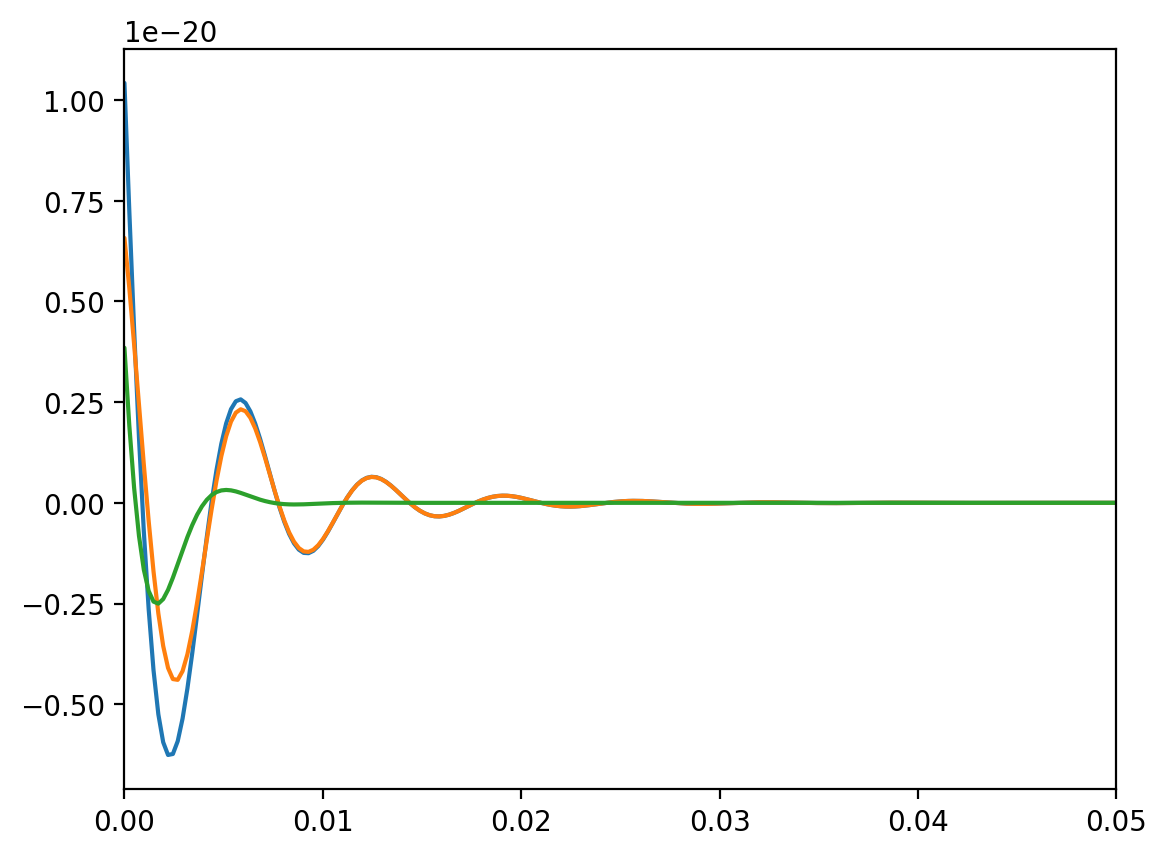

In [36]:
# BILBY_signal()
pl.plot(t_range, signal220+signal221)
pl.plot(t_range, signal220)
pl.plot(t_range, signal221)
pl.xlim(0, 0.05)

Text(0.5, 1.0, 'MF SNR')

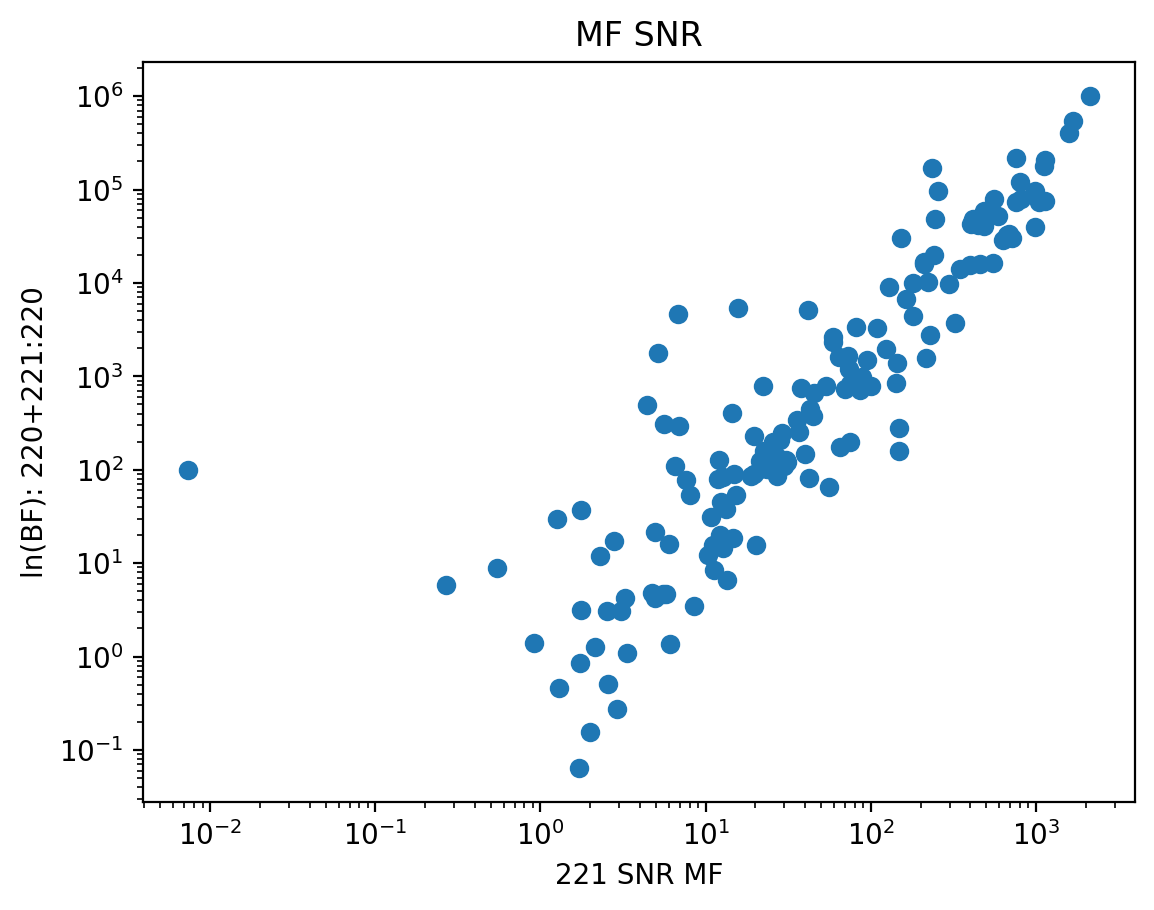

In [28]:
pl.loglog(result_arr[:,1], result_arr[:,2], 'o')
pl.xlabel("221 SNR MF")
pl.ylabel("ln(BF): 220+221:220")
pl.title("MF SNR")

Text(0.5, 1.0, 'Optimal SNR')

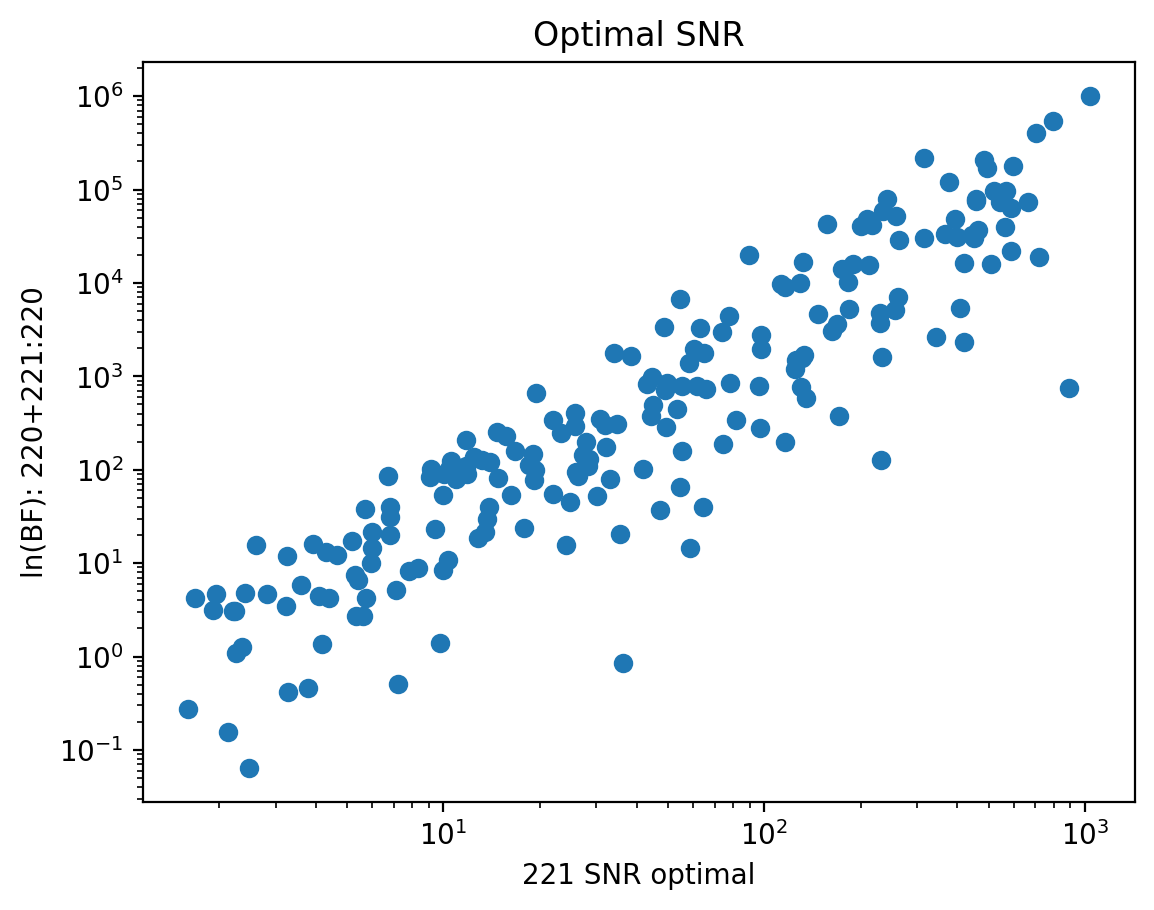

In [29]:
pl.loglog(result_arr[:,0], result_arr[:,2], 'o')
pl.xlabel("221 SNR optimal")
pl.ylabel("ln(BF): 220+221:220")
pl.title("Optimal SNR")

In [13]:
np.count_nonzero(np.isnan(np.log10(result_arr[:,1])))

/tmp/ipykernel_114918/459240969.py:1: RuntimeWarning: invalid value encountered in log10
  np.count_nonzero(np.isnan(np.log10(result_arr[:,1])))


2

In [30]:
print(np.polyfit(np.log10(result_arr[:,0]), np.log10(result_arr[:,1]),deg=1, cov=True))

(array([nan, nan]), array([[nan, nan],
       [nan, nan]]))


/tmp/ipykernel_8106/1669318335.py:1: RuntimeWarning: invalid value encountered in log10
  print(np.polyfit(np.log10(result_arr[:,0]), np.log10(result_arr[:,1]),deg=1, cov=True))


# Evidence

In [19]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

## NNI

In [35]:
N = 20
results = np.empty((N, 5))
input['srate'] = 4096*1

for i in range(N):
    injected = [np.random.uniform(45, 150, 1)[0], np.random.uniform(0, 0.85, 1)[0]]
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]
    signal220 = np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    signal221 = np.real(np.exp(-1j*omega221*abs(t_range)/(injected[0]*T_MSUN)))
#     rand_amp = np.random.uniform(0.7, 1, 1)[0]
    signal = 1*signal220 + 1*signal221
    waveform = qnm_filter.RealData(signal, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.condition_data('original_data')
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = np.random.uniform(0.01, 0.1, 1)[0]**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()
    
    fit.pure_nr = {}
    fit.pure_nr['H1'] = qnm_filter.RealData((1-rand_amp)*signal221, index=t_range)
    fit.condition_data('pure_nr')
    template = fit.truncate_data(fit.pure_nr)['H1']
    SNR = fit.compute_SNR(None, template, 'H1', optimal=True)

    _, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,0,'p')])
    _, evidence221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,1,'p')])
    _, evidence220_221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, 
                                                  model_list=[(2,2,0,'p'),(2,2,1,'p')])
    nofilter = logsumexp(
        np.array(
            [fit.compute_likelihood(apply_filter=False)]
            * len(massspace)
            * len(chispace)
        )
    )

    results[i] = np.array([SNR, nofilter, evidence220, evidence221, evidence220_221])

Text(0, 0.5, 'BF(220+221 / 220)')

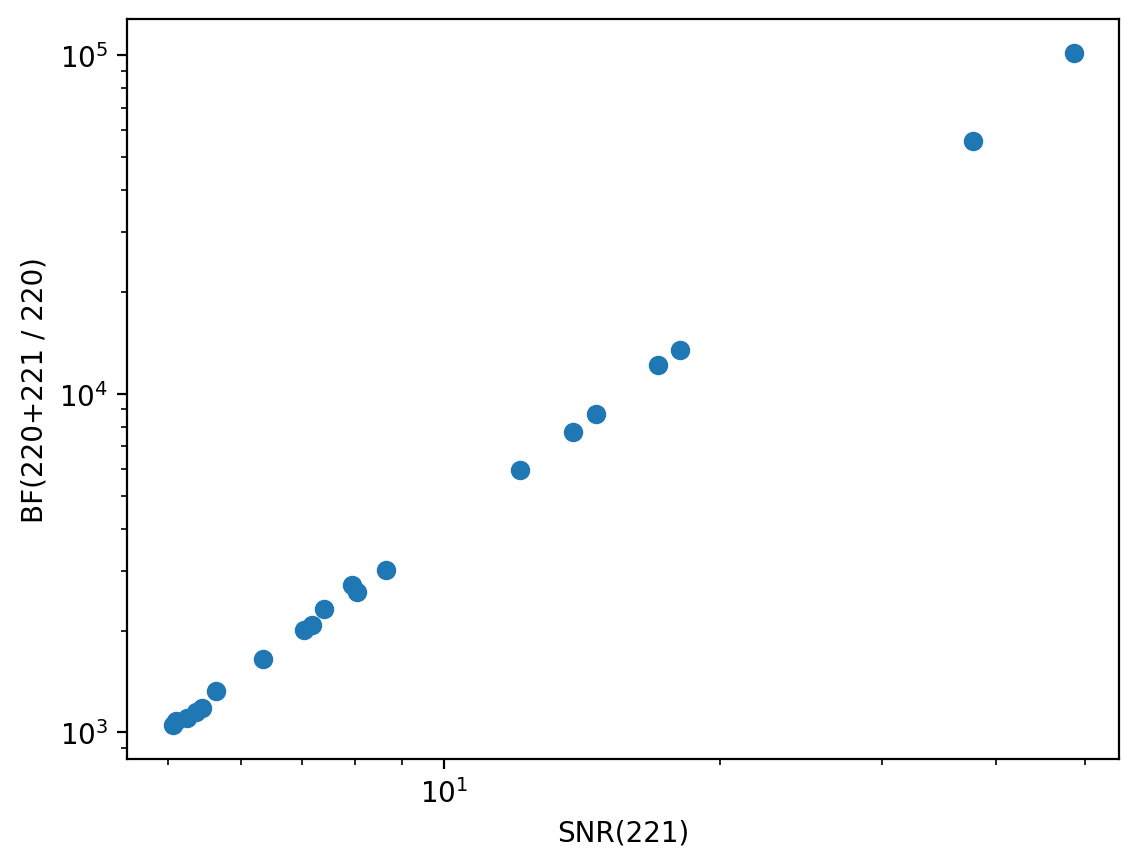

In [39]:
pl.loglog(results[:,0], results[:,4]-results[:,1], 'o')
pl.xlabel("SNR(221)")
pl.ylabel("BF(220+221 / 220)")
# pl.xlim(3, 7)
# pl.ylim(-5, 1)

## Colored noise

## Finer grid

In [350]:
delta_mass = 0.2
delta_chi = 0.01
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [351]:
input['srate'] = 4096
SNR_arr = []
bayes_arr = []
N = 10
repeats = 6
std_arr = np.repeat(np.linspace(0.01, 0.1, N), repeats)

for i in std_arr:
    injected = [np.random.uniform(60, 80, 1)[0], np.random.uniform(0.4, 0.6, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', srate, 2, start_time=-1)
    noise = qnm_filter.bilby_get_strain(bilby_ifo, time_offset=0)
    noise *= i / np.std(noise)
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.detector_alignment()
    fit.condition_data('pure_noise')
    fit.condition_data('original_data')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    _, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,0,'p')])
    _, evidence221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,1,'p')])
    
    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.condition_data("original_data")
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    bayes_arr.append(evidence220 - evidence221)

KeyboardInterrupt: 

Text(0, 0.5, 'log$_{10}(-ln(BF(221/220)))$')

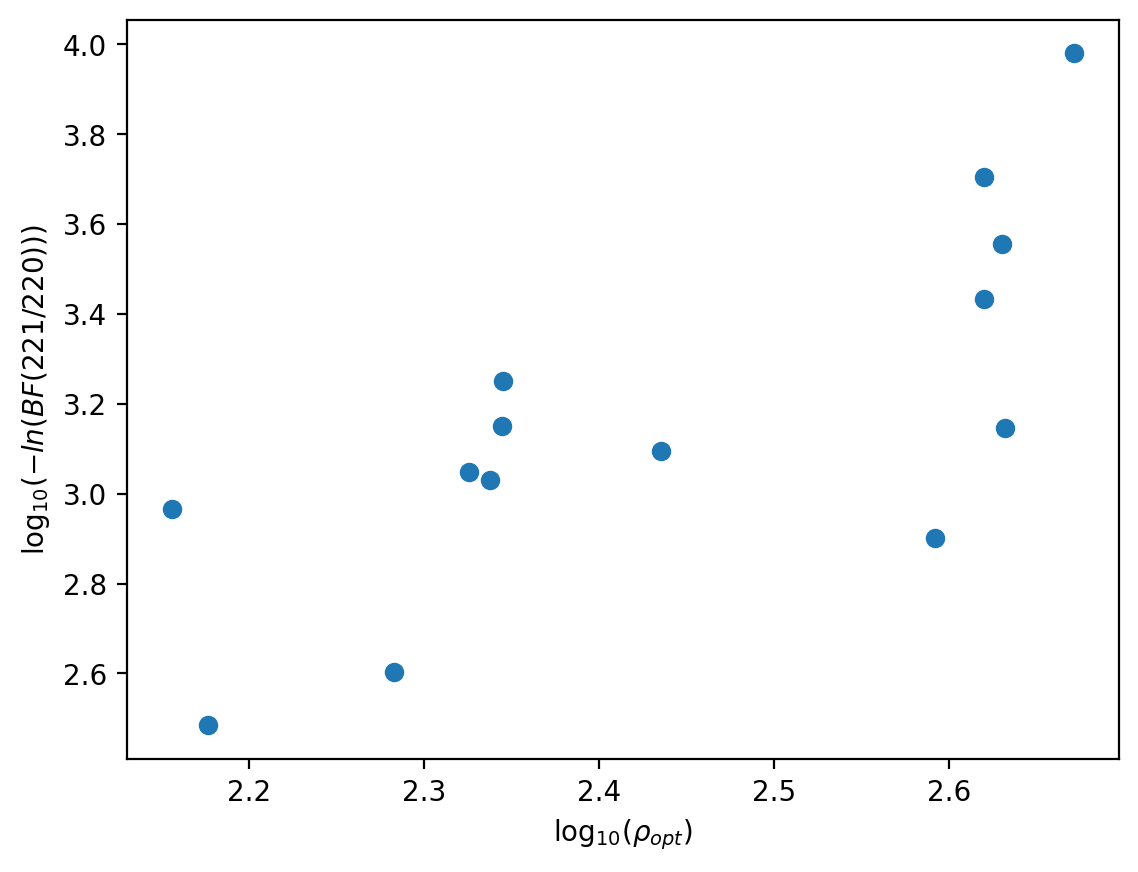

In [352]:
pl.plot(np.log10(SNR_arr), np.log10(bayes_arr), 'o')
pl.xlabel(r'log$_{10}(\rho_{opt}$)')
pl.ylabel(r'log$_{10}(-ln(BF(221/220)))$')
# pl.text(0.6, 2.05, 'Slope = 2')

## Coarser grid

In [ ]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [322]:
input['srate'] = 4096
SNR_arr = []
bayes_arr = []
N = 10
repeats = 6
std_arr = np.repeat(np.linspace(0.01, 0.1, N), repeats)

for i in std_arr:
    injected = [np.random.uniform(60, 80, 1)[0], np.random.uniform(0.4, 0.6, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', srate, 2, start_time=-1)
    noise = qnm_filter.bilby_get_strain(bilby_ifo, time_offset=0)
    noise *= i / np.std(noise)
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.detector_alignment()
    fit.condition_data('pure_noise')
    fit.condition_data('original_data')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    _, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,0,'p')])
    _, evidence221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,1,'p')])
    
    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.condition_data("original_data")
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    bayes_arr.append(evidence221 - evidence220)

In [332]:
temp_SNR = np.log10(SNR_arr)
temp_bayes = np.log10(np.multiply(-1, bayes_arr))

In [333]:
median_SNR = np.median(np.reshape(temp_SNR, (N, repeats)), axis=1)
std_SNR = np.std(np.reshape(temp_SNR, (N, repeats)), axis=1)
median_bayes = np.median(np.reshape(temp_bayes, (N, repeats)), axis=1)
std_bayes = np.std(np.reshape(temp_bayes, (N, repeats)), axis=1)

Text(0, 0.5, 'log$_{10}(-ln(BF)')

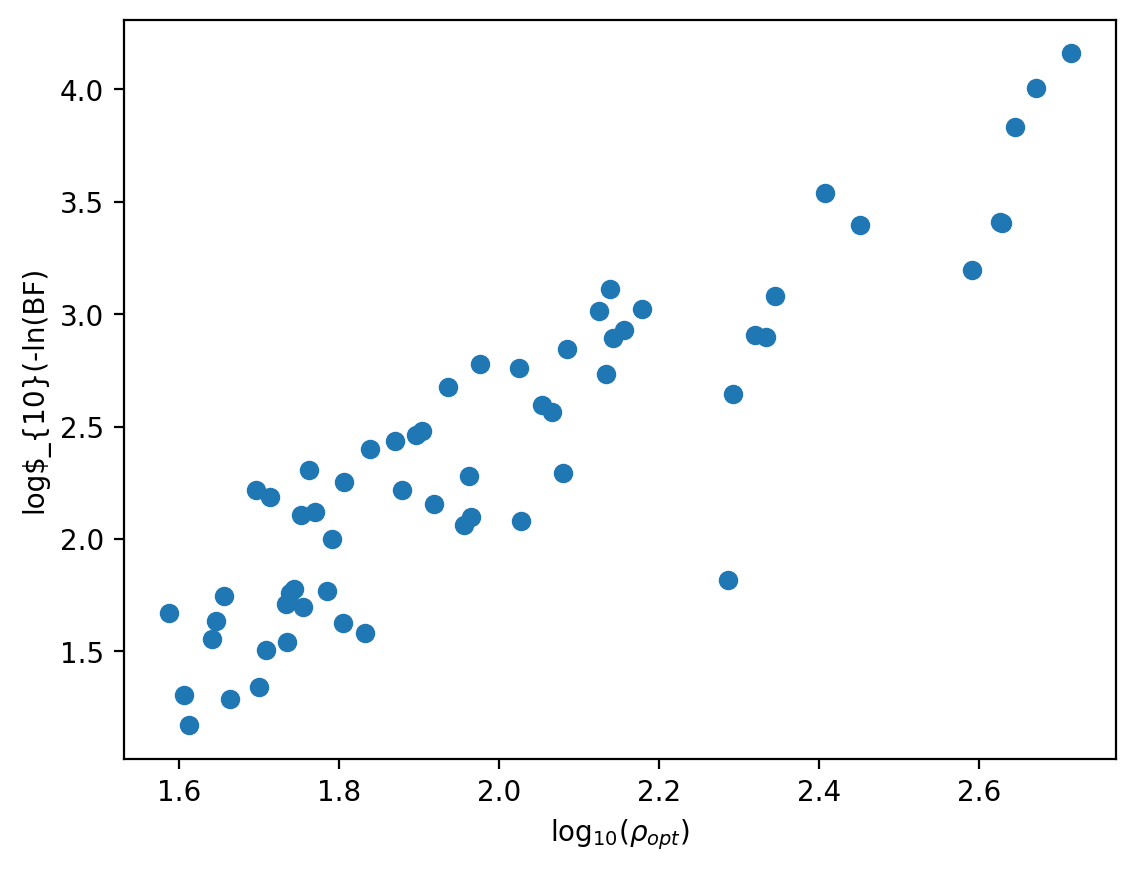

In [340]:
pl.plot(temp_SNR, temp_bayes, 'o')
# pl.fill_between(median_SNR, median_bayes-std_bayes, median_bayes+std_bayes, color='k', alpha=0.2)
pl.xlabel(r'log$_{10}(\rho_{opt}$)')
pl.ylabel(r'log$_{10}(-ln(BF)')
# pl.text(0.6, 2.05, 'Slope = 2')

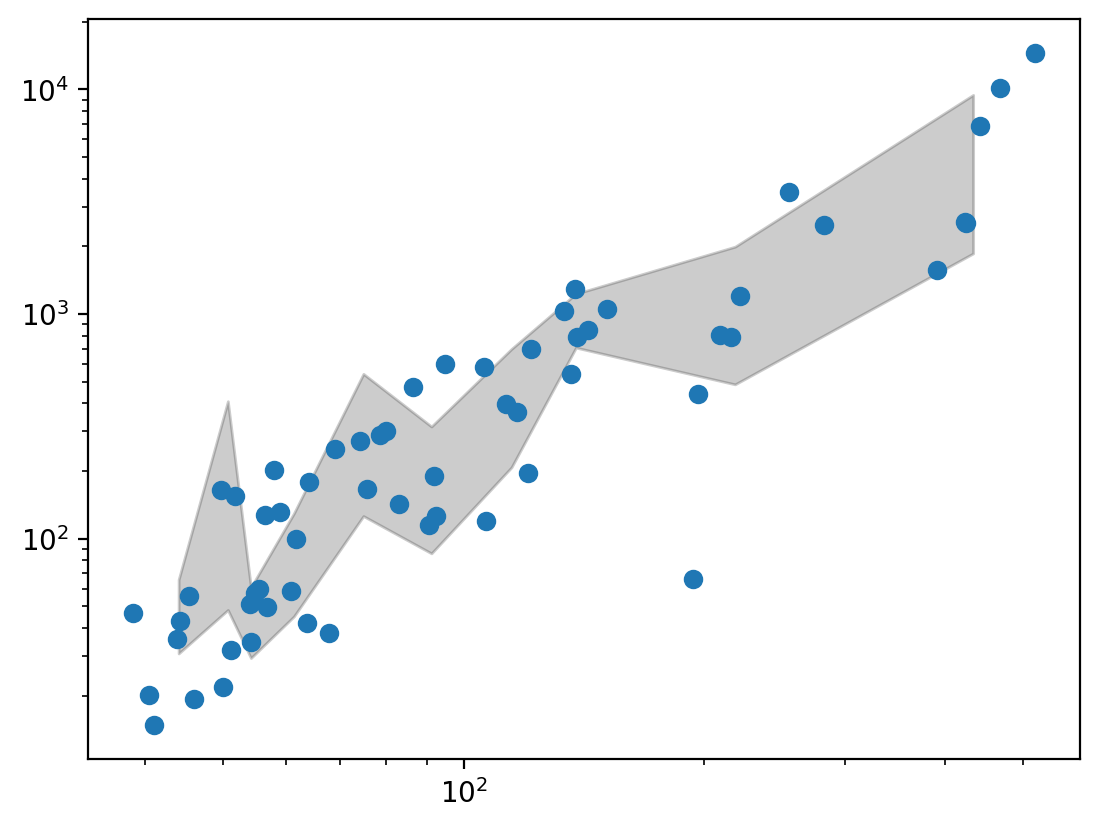

In [348]:
pl.loglog(SNR_arr, np.multiply(-1,bayes_arr), 'o')
pl.fill_between(10**median_SNR, 10**(median_bayes-std_bayes), 10**(median_bayes+std_bayes), color='k', alpha=0.2)


Text(0, 0.5, 'log$_{10}(-ln(BF)')

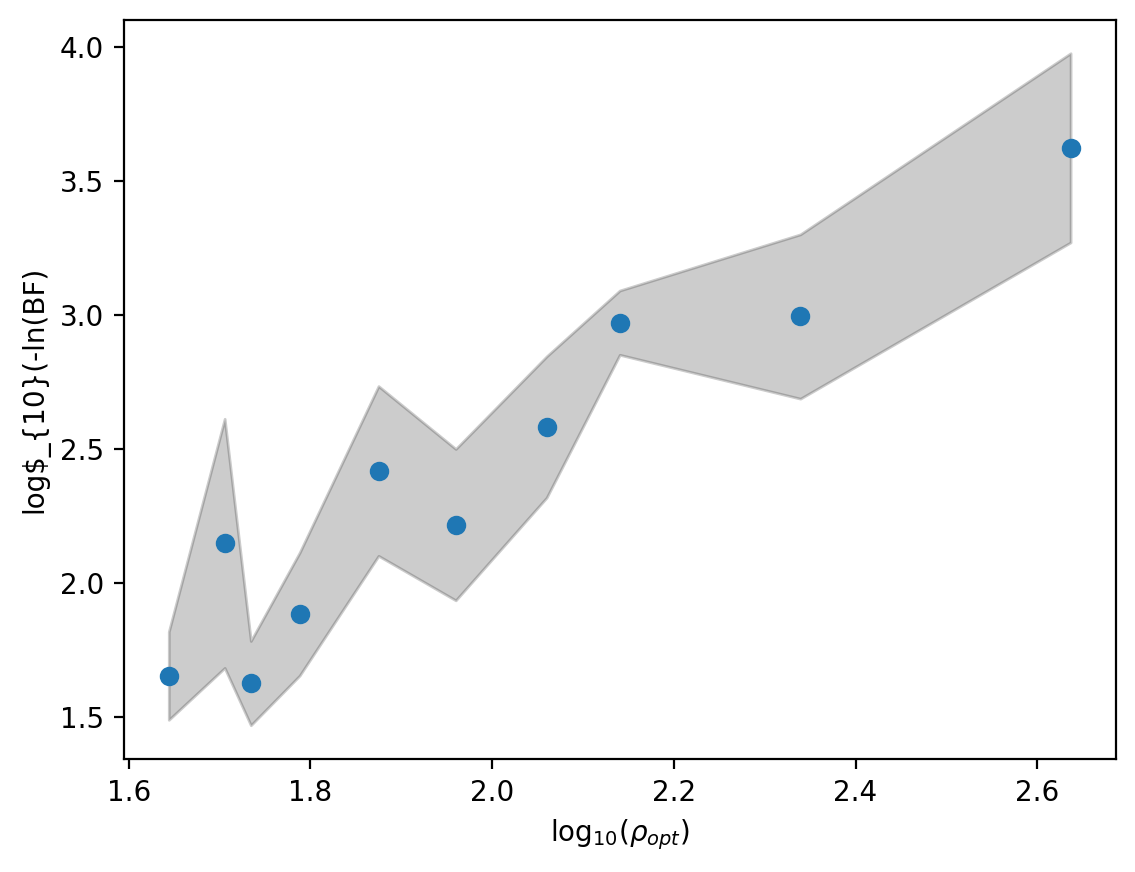

In [339]:
# pl.plot(median_SNR, median_bayes, 'o')
# # pl.fill_between(median_SNR, median_bayes-std_bayes, median_bayes+std_bayes, color='k', alpha=0.2)
# pl.xlabel(r'log$_{10}(\rho_{opt}$)')
# pl.ylabel(r'log$_{10}(-ln(BF)')
# # pl.text(0.6, 2.05, 'Slope = 2')

In [341]:
np.polyfit(median_SNR, median_bayes,deg=1, cov=True)

(array([ 1.94929013, -1.46470622]),
 array([[ 0.04880473, -0.09703878],
        [-0.09703878,  0.19728017]]))

## Multiple modes

In [ ]:
input['srate'] = 4096
SNR_arr = []
bayes_arr = []
N = 3 
repeats = 3
std_arr = np.repeat(np.linspace(0.01, 0.1, N), repeats)

for i in std_arr:
    injected = [np.random.uniform(60, 80, 1)[0], np.random.uniform(0.4, 0.6, 1)[0]]
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]
    signal220 = np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    signal221 = np.real(np.exp(-1j*omega221*abs(t_range)/(injected[0]*T_MSUN)))
    rand_amp = np.random.uniform(0.7, 1, 1)[0]
    signal = rand_amp*signal220 + (1-rand_amp)*signal221
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', srate, 2, start_time=-1)
    noise = qnm_filter.bilby_get_strain(bilby_ifo, time_offset=0)
    noise *= i / np.std(noise)
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.detector_alignment()
    fit.condition_data('pure_noise')
    fit.condition_data('original_data')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    _, evidence2201 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, 
                                                  model_list=[(2,2,0,'p'), (2,2,1,'p')])
    _, evidence221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,1,'p')])
    
    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.condition_data("original_data")
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    bayes_arr.append(evidence221 - evidence220)